In [1]:
import cv2 as cv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import sys

import nibabel as nib 
import imageio 
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorboard.plugins import projector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers, regularizers

from tensorflow.keras.optimizers import Adagrad
import tensorlayer as tl

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#read 2D slices of raw data
dirname = "./Train_img"
Img = []

for root,dirs,files in os.walk(dirname):
    for file in files:
        s = root[-3:]
        if s != 'seg': # find the folder with data without labels
          img_path = os.path.join(root,file)
          #print(img_path)
          img = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
          img = cv.bitwise_not(img)
          img = cv. resize(img, (256,256))
          Img.append(img)
          





In [4]:
#read slices with labels for RV and myocardial parts only
dirname = "./Mask_noLV"
Img_noLV = []

for root,dirs,files in os.walk(dirname):
    for file in files:
          img_path = os.path.join(root,file)
          #print(img_path)
          img = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
          img = cv.bitwise_not(img)
          img = cv. resize(img, (256,256))
          Img_noLV.append(img)

Img_noLV = np.array(Img_noLV)
Img_noLV.shape

(1902, 256, 256)

In [ ]:
#load the mask with only the LV label      
dirname = "./Mask_LV"
mask_Lv = []

for root,dirs,files in os.walk(dirname):
    for file in files:
          img_path = os.path.join(root,file)
          #print(img_path)
          img = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
          img = cv. resize(img, (256,256))
          mask_Lv.append( img)
Img = np.array(Img)
mask_Lv = np.array(mask_Lv)

In [15]:
# definition of the network
def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(input_tensor)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('relu')(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer='he_normal')(encoder)
    encoder = tf.keras.layers.BatchNormalization()(encoder)
    encoder = tf.keras.layers.Activation('relu')(encoder)
    #encoder = Dropout(0.5)(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    #encoder = Dropout(0.5)(encoder)
    encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = Conv2D(num_filters, (2, 2), padding='same', kernel_initializer='he_normal')(UpSampling2D((2, 2))(input_tensor))
    decoder = Concatenate()([concat_tensor, decoder])
    decoder = conv_block(decoder, num_filters)
    return decoder

def unet(input_shape=(256, 256, 1), num_classes=2):
    inputs = Input(shape=input_shape)
    # Encoder
    encoder1_pool, encoder1 = encoder_block(inputs, 64)
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
    center = conv_block(encoder4_pool, 1024)
    # Decoder
    decoder4 = decoder_block(center, encoder4, 512)
    decoder3 = decoder_block(decoder4, encoder3, 256)
    decoder2 = decoder_block(decoder3, encoder2, 128)
    decoder1 = decoder_block(decoder2, encoder1, 64)
    # Output
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(decoder1)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [16]:
from tensorflow.keras.optimizers import Adam

seg_model = unet()

seg_model.summary()



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 256, 256, 64) 256         conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 256, 256, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [17]:
# data are divided into training set, validation set and test set according to 0.6, 0.3 and 0.1.
X_train, X_val, y_train, y_val = train_test_split(Img_noLV, mask_Lv, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.25, random_state=42)

shape = X_train.shape[1]*X_train.shape[2]

# change the data range to 0-1
X_train = X_train/255
y_train = y_train/255

X_test = X_test/255
y_test = y_test/255

X_val = X_val/255
y_val = y_val/255


In [18]:
# classification targets: LV and background
n = 2

# convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=n)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=n)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=n)
# confirm the shape after transformation
print(y_train.shape)  

(1141, 256, 256, 2)


In [19]:
# specify the visible GPU
gpus = tf.config.experimental.list_physical_devices('GPU')

tf.config.experimental.set_visible_devices(gpus[0], 'GPU')


In [10]:
tf.random.set_seed(0)
np.random.seed(0)

In [20]:
batch_size = 16
epochs = 100


seg_model = unet()
#seg_model.compile(optimizer=Adam(lr=0.00001), loss=BinaryCrossentropy(), metrics=['accuracy'])
seg_model.compile(optimizer=Adam(lr=0.00005), loss=BinaryCrossentropy(), metrics=['accuracy'])

# train the model
with tf.device('/GPU:0'):
    history = seg_model.fit( X_train,
                            y_train,
                               epochs=epochs,
                               #initial_epoch = 200,
                               batch_size=batch_size,
                               validation_batch_size = batch_size,
                               validation_data = (X_val,y_val)
                               )



Epoch 1/100
72/72 [==============================] - 60s 815ms/step - loss: 0.4582 - accuracy: 0.9121 - val_loss: 0.5590 - val_accuracy: 0.9727
Epoch 2/100
72/72 [==============================] - 50s 695ms/step - loss: 0.2431 - accuracy: 0.9992 - val_loss: 0.5060 - val_accuracy: 0.9947
Epoch 3/100
72/72 [==============================] - 53s 732ms/step - loss: 0.2110 - accuracy: 0.9994 - val_loss: 0.3721 - val_accuracy: 0.9979
Epoch 4/100
72/72 [==============================] - 53s 739ms/step - loss: 0.1932 - accuracy: 0.9995 - val_loss: 0.2783 - val_accuracy: 0.9991
Epoch 5/100
72/72 [==============================] - 48s 665ms/step - loss: 0.1795 - accuracy: 0.9996 - val_loss: 0.2229 - val_accuracy: 0.9991
Epoch 6/100
72/72 [==============================] - 44s 619ms/step - loss: 0.1676 - accuracy: 0.9996 - val_loss: 0.1818 - val_accuracy: 0.9995
Epoch 7/100
72/72 [==============================] - 43s 599ms/step - loss: 0.1568 - accuracy: 0.9996 - val_loss: 0.1582 - val_accuracy:

In [28]:
# save the weights
seg_model.save_weights('0427_seg(inputmask).h5')

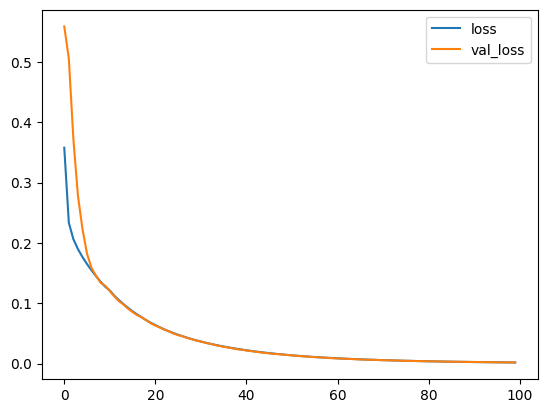

In [21]:
plt.plot(history.epoch, history.history.get('loss'),label='loss')
plt.plot(history.epoch, history.history.get('val_loss'),label='val_loss')
plt.legend()


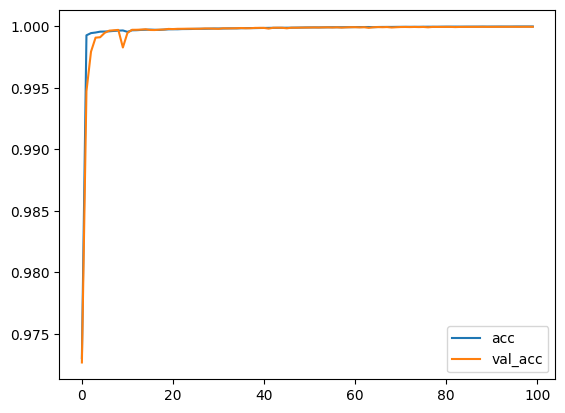

In [22]:
plt.plot(history.epoch, history.history.get('accuracy'),label='acc')
plt.plot(history.epoch, history.history.get('val_accuracy'),label='val_acc')
plt.legend()


In [29]:
# evaluate the model by the test set
seg_model.evaluate(X_test,y_test)

6/6 [==============================] - 3s 496ms/step - loss: 0.0018 - accuracy: 1.0000


[0.0017841719090938568, 0.9999642968177795]

In [24]:


# Load the trained model
model = unet()

model.compile(optimizer=Adam(lr=0.00005), loss=BinaryCrossentropy(), metrics=['accuracy'])

model.load_weights('0427_seg(inputmask).h5')



In [26]:
# predict using trained models
# iterate through folders to make predictions
dirname = "./Test_img"
test_img = []
mask_nolv= []
for root,dirs,files in os.walk(dirname):
    for file in files:
    
        s = root[-3:]
        if s != 'seg': #find the folder with data without labels
            img_path = os.path.join(root,file)
            print(img_path)
            img = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
            img = cv.bitwise_not(img)
            img = cv. resize(img, (256,256))
            img = np.expand_dims(img,axis=0)
            print(img.shape)
            test_img = img/255

            root_seg = root + '_seg'
            img_path = os.path.join(root_seg,file)
            print(img_path)
            img = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
            img = cv.bitwise_not(img)
            img = cv. resize(img, (256,256))
            img = np.expand_dims(img,axis=0)
            print(img.shape)
            mask_img = img/255
            
            test_img = np.array(test_img)
            mask_img = np.array(mask_img)
            print(test_img.shape, mask_img.shape)

            prediction = model.predict(mask_img) #predict
            print(prediction.shape)
            img = prediction[0,:,:,1] *255
            
            print(root[-6:])
            result_path = os.path.join('./Test_Mask_LV(input_mask)',root[-6:])
            if not os.path.exists(result_path):
                os.mkdir(result_path)
            cv.imwrite(os.path.join(result_path,file),  img) #写入 mask_lv3.0/00x_Ex_seg文件夹 0-255
            mask = Image.open(os.path.join(result_path,file))
            mask.save(os.path.join(result_path,file))
            

./Test_img\101_ED\0.png
(1, 256, 256)
./Test_img\101_ED_seg\0.png
(1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256, 2)
101_ED
./Test_img\101_ED\1.png
(1, 256, 256)
./Test_img\101_ED_seg\1.png
(1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256, 2)
101_ED
./Test_img\101_ED\2.png
(1, 256, 256)
./Test_img\101_ED_seg\2.png
(1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256, 2)
101_ED
./Test_img\101_ED\3.png
(1, 256, 256)
./Test_img\101_ED_seg\3.png
(1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256, 2)
101_ED
./Test_img\101_ED\4.png
(1, 256, 256)
./Test_img\101_ED_seg\4.png
(1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256, 2)
101_ED
./Test_img\101_ED\5.png
(1, 256, 256)
./Test_img\101_ED_seg\5.png
(1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256, 2)
101_ED
./Test_img\101_ED\6.png
(1, 256, 256)
./Test_img\101_ED_seg\6.png
(1, 256, 256)
(1, 256, 256) (1, 256, 256)
(1, 256, 256, 2)
101_ED
./Test_img\101_ED\7.png
(1, 256, 256)
./Test_img\101_ED_seg\7.png
(1, 256, 2

In [4]:
# segment the prediction results by a threshold of 0.5
dirname = "./Test_Mask_LV(input_mask)"

for root,dirs,files in os.walk(dirname):
    for file in files:
          img_path = os.path.join(root,file)
          print(img_path)
          img = cv.imread(img_path,cv.IMREAD_GRAYSCALE)
          #print(img)
          for i in range(img.shape[0]):
            for j in range(img.shape[1]):
              if img[i][j] > 128 : #255对应的01 右心室
                img[i][j] = 255
              else:
                img[i][j] = 0
          result_path = os.path.join('./Test_Mask_LV',root[-6:])
          if not os.path.exists(result_path):
              os.mkdir(result_path)
          imageio.imwrite(os.path.join(result_path,file), img) #写入 mask_rv/00x_Ex_seg文件夹 0-255
          mask = Image.open(os.path.join(result_path,file))
          mask.save(os.path.join(result_path,file))


./Test_Mask_LV(input_mask)\101_ED\0.png
./Test_Mask_LV(input_mask)\101_ED\1.png
./Test_Mask_LV(input_mask)\101_ED\2.png
./Test_Mask_LV(input_mask)\101_ED\3.png
./Test_Mask_LV(input_mask)\101_ED\4.png
./Test_Mask_LV(input_mask)\101_ED\5.png
./Test_Mask_LV(input_mask)\101_ED\6.png
./Test_Mask_LV(input_mask)\101_ED\7.png
./Test_Mask_LV(input_mask)\101_ED\8.png
./Test_Mask_LV(input_mask)\101_ED\9.png
./Test_Mask_LV(input_mask)\101_ES\0.png
./Test_Mask_LV(input_mask)\101_ES\1.png
./Test_Mask_LV(input_mask)\101_ES\2.png
./Test_Mask_LV(input_mask)\101_ES\3.png
./Test_Mask_LV(input_mask)\101_ES\4.png
./Test_Mask_LV(input_mask)\101_ES\5.png
./Test_Mask_LV(input_mask)\101_ES\6.png
./Test_Mask_LV(input_mask)\101_ES\7.png
./Test_Mask_LV(input_mask)\101_ES\8.png
./Test_Mask_LV(input_mask)\101_ES\9.png
./Test_Mask_LV(input_mask)\102_ED\0.png
./Test_Mask_LV(input_mask)\102_ED\1.png
./Test_Mask_LV(input_mask)\102_ED\10.png
./Test_Mask_LV(input_mask)\102_ED\11.png
./Test_Mask_LV(input_mask)\102_ED\12.p